In [1]:
import pandas as pd
import requests
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
import re
from datetime import datetime, timedelta
import time
#scraping imports
# from bs4 import BeautifulSoup
# from selenium.webdriver.common.by import By
# from selenium.webdriver.support.ui import WebDriverWait
# from selenium import webdriver
# from selenium.webdriver.support.ui import Select
# from selenium.webdriver.support import expected_conditions as EC
import seaborn as sns
import nltk
nltk.download('punkt')
nltk.download('stopwords')
sns.set(style='whitegrid',palette='pastel')
from pylab import rcParams
matplotlib.rcParams['pdf.fonttype'] = 42


%matplotlib inline

[nltk_data] Downloading package punkt to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/lilyliu-
[nltk_data]     krason/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# !pip install nltk

In [3]:
df=pd.read_csv('merged_final_11202019.csv',thousands=',')

In [4]:
df=df.drop(columns=['raised','goal'])

In [5]:
df.head(3)

,Unnamed: 0,funds,link,location,title,created_date,summary,tag,state,goal_int,raised_int
0,0,"\n$2,710 raised of $6,500",https://www.gofundme.com/steven-crowder-live-a...,"Dallas, TX",Steven Crowder Live at SMU!,"March 7, 2018",SMU College Republicans is bringing comedian S...,rep,TX,6500.0,2710.0
1,1,"\n$12,857 raised of $10,000",https://www.gofundme.com/reopen-a-nc-republica...,"Brookline, MA",Dems help reopen a NC Repub office,"October 16, 2016",NOTE: We reached our goal and then some in les...,rep,MA,10000.0,12857.0
2,2,"\n$13,171 raised of $20,000",https://www.gofundme.com/troopersanchez,"Mcallen, TX",Funds for Trooper Moises Sanchez,"April 7, 2019","￼Moises Sanchez, a Texas State Trooper, was sh...",rep,TX,20000.0,13171.0


In [6]:
#getting a look at how many campaigns with word "democrat" vs "republican"
df.tag.value_counts()

rep    871
dem    856
Name: tag, dtype: int64

In [7]:
#overlap count
df.link.value_counts()[df.link.value_counts()==2].count()

239

In [8]:
#converting dates
df['created_date']=df.created_date.str.replace('Created ','')

# df['date']=pd.to_datetime(df.created_date,infer_datetime_format=True)

In [9]:
#you'll have to drop the 1 day ago, 3 days ago...
ago_df=df[df.created_date.str.contains('ago')==True]
ago_df['created_date']=ago_df.created_date.str.replace(' ago','')

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [10]:
ago_df.head(3)

,Unnamed: 0,funds,link,location,title,created_date,summary,tag,state,goal_int,raised_int
53,58,"\n$0 raised of $5,200",https://www.gofundme.com/educate-republican-se...,"Plano, TX",Educate Republican Senators and Congressmen,4 days,This GoFundMe is to raise money to send each a...,rep,TX,5200.0,0.0
54,59,"\n$0 raised of $1,000",https://www.gofundme.com/empowering-conservati...,"Lake Forest, IL",Empowering Conservatives @ Lake Forest College,4 days,This GoFundMe is designed to raise money for e...,rep,IL,1000.0,0.0
55,60,"\n$0 raised of $5,000",https://www.gofundme.com/ndsu-college-republicans,"Fargo, ND",NDSU College Republicans,6 days,We are the NDSU College Republicans. We are ve...,rep,ND,5000.0,0.0


In [11]:
# turn hours ago to 1 day ago
ago_df.loc[ago_df.created_date.str.contains("hour"), 'created_date']='1 day'

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


In [12]:
# extract the date difference
ago_df['data_diff'] = ago_df.created_date.str.extract(r'(\d+)', expand=False).astype(int)

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [13]:
#since this data was grabbed 7/17 we'll have to subtract a few more days
ago_df['created_actual']=ago_df['data_diff'].apply(lambda x: pd.datetime.now().date()-timedelta(days=x+5))

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [14]:
ago_df=ago_df.drop(columns=['created_date','data_diff'])

In [15]:
ago_df=ago_df.rename(columns={'created_actual':'created_date'})

In [16]:
df=df[df.created_date.str.contains('ago')==False]

In [17]:
df=df.append(ago_df)

/Users/lilyliu-krason/.pyenv/versions/3.7.1/lib/python3.7/site-packages/pandas/core/frame.py:6692: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort)


In [18]:
#convert to datetime and add Year, Month, Weekday
df['year']=pd.to_datetime(df.created_date).dt.year
df['month']=pd.to_datetime(df.created_date).dt.month
df['weekday_name'] =pd.to_datetime(df.created_date).dt.weekday_name

# Using Crosstab to Compare "Democrat" vs "Republican"

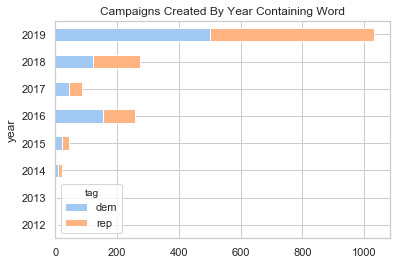

In [19]:
pd.crosstab(index=df.year,columns=df.tag).plot(kind='barh',stacked=True,title='Campaigns Created By Year Containing Word')

In [20]:
overlap=df[df.link.isin(df.link.value_counts()[df.link.value_counts()==2].index)]

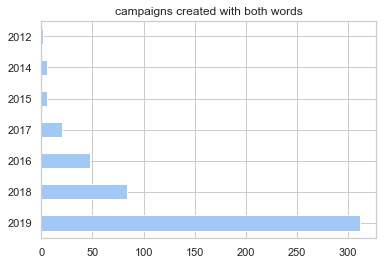

In [21]:
overlap.year.value_counts().plot(kind='barh',title='campaigns created with both words')

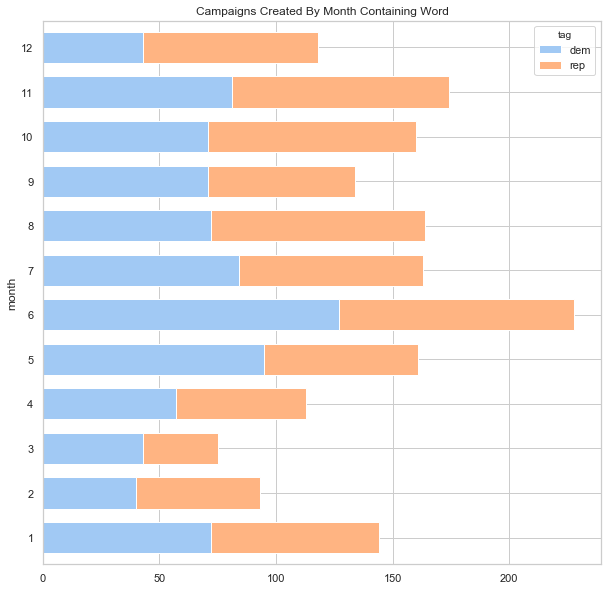

In [22]:
pd.crosstab(index=df.month,columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Month Containing Word',figsize=(10,10))

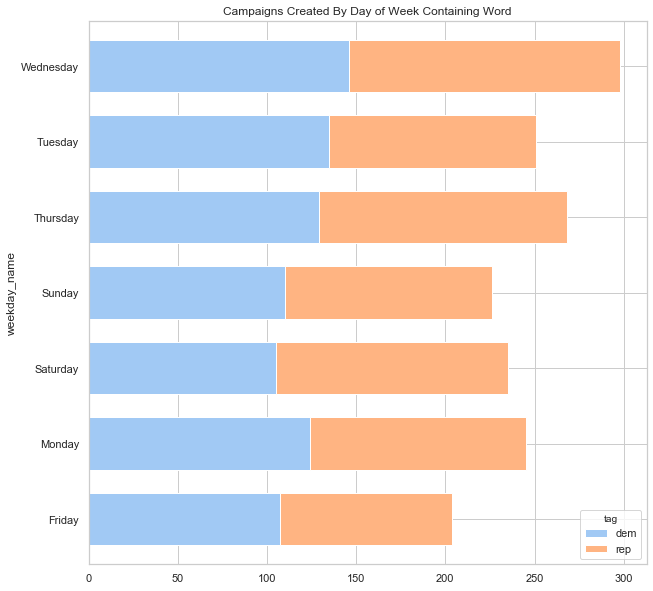

In [23]:
pd.crosstab(index=df['weekday_name'],columns=df.tag).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Day of Week Containing Word',figsize=(10,10))

In [24]:
df.groupby('tag')['goal_int'].median()

tag
dem     5000.0
rep    10000.0
Name: goal_int, dtype: float64

In [25]:
overlap.goal_int.median()

10000.0

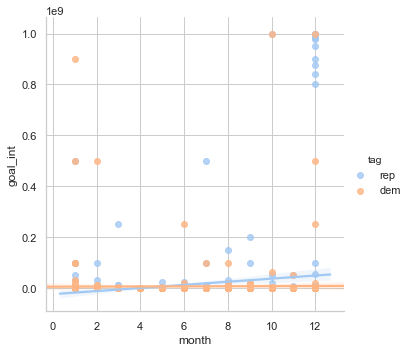

In [26]:
sns.lmplot(x='month',y='goal_int',hue='tag',data=df)

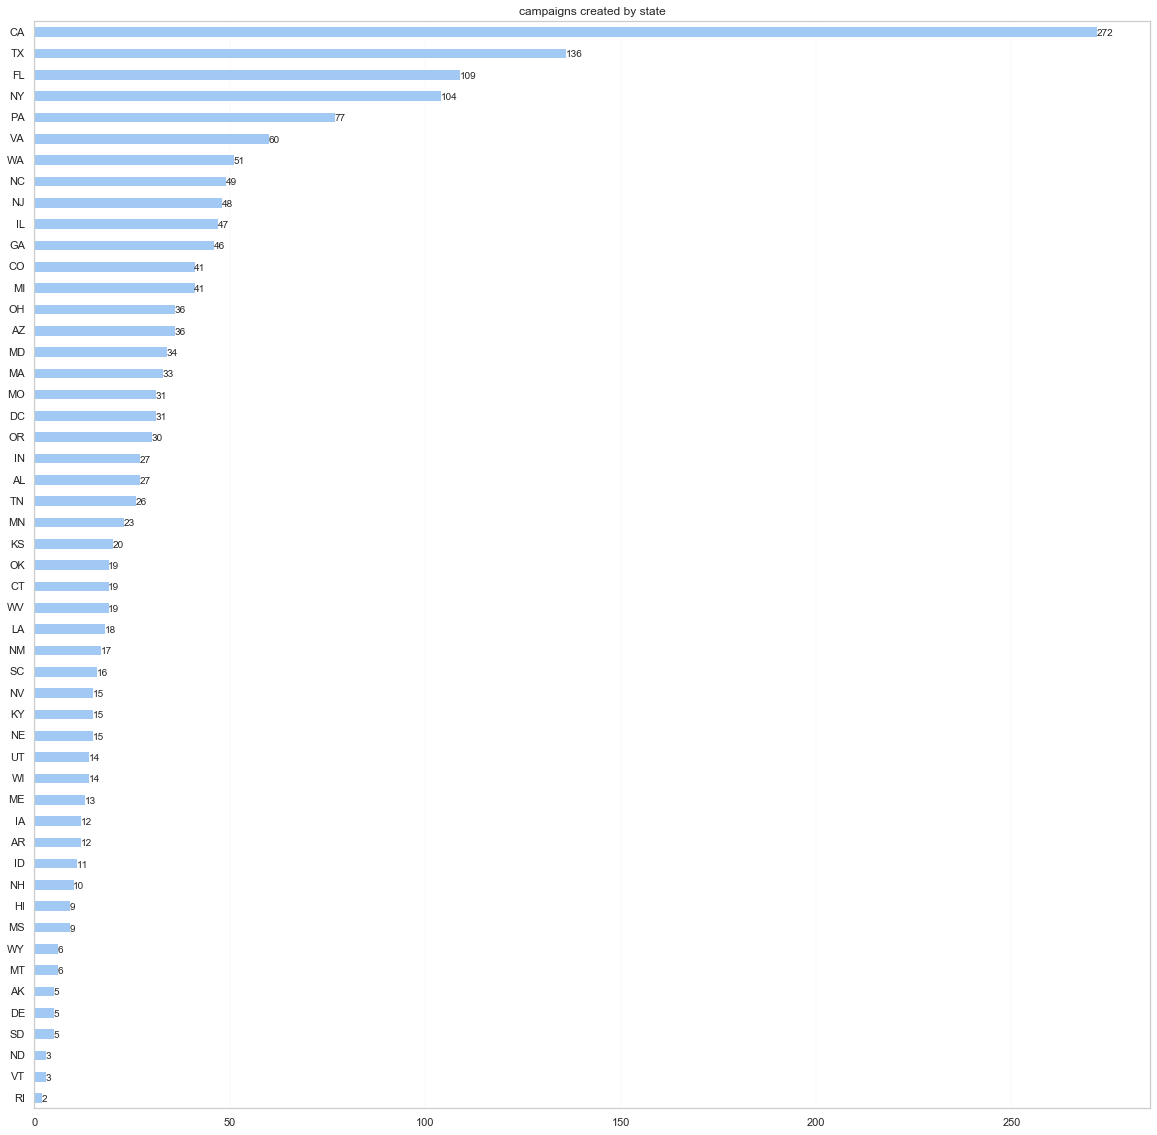

In [27]:
ax=df.state.value_counts().sort_values(ascending=True).plot(kind='barh',figsize=(20,20),title='campaigns created by state')
ax.grid(linestyle='-', linewidth='0.1')
#remove grid lines
plt.gca().yaxis.grid(False)
for i, v in enumerate(df.state.value_counts(ascending=True).apply(lambda x: round(x, 1)).reset_index(drop=True)):
     ax.text(v-0.1, i-0.2, str(v))

In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1727 entries, 0 to 1538
Data columns (total 14 columns):
Unnamed: 0      1727 non-null int64
created_date    1727 non-null object
funds           1727 non-null object
goal_int        1727 non-null float64
link            1727 non-null object
location        1727 non-null object
raised_int      1727 non-null float64
state           1727 non-null object
summary         1727 non-null object
tag             1727 non-null object
title           1727 non-null object
year            1727 non-null int64
month           1727 non-null int64
weekday_name    1727 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 202.4+ KB


In [30]:
state_agg=df.groupby('state').agg({'raised_int': [min, max, sum]})
state_agg.columns = state_agg.columns.droplevel(level=0)
state_agg=state_agg.rename(columns={
    "min": "min_raised", "max": "max_raised", "sum": "sum_raised",state_agg.index.name:'state'})
state_agg=state_agg.reset_index()

In [31]:
#getting some total raised numbers by state
state_det=df.groupby('state').agg({'raised_int': [min, max, sum,'mean']})
state_det.columns = state_det.columns.droplevel(level=0)
state_det=state_det.rename(columns={"mean": "avg_raised",
    "min": "min_raised", "max": "max_raised", "sum": "sum_raised",state_agg.index.name:'state'})
state_det=state_det.reset_index()


In [32]:
state_det
state_det.to_csv('state_det_raw_graphs1120.csv',index=False)

In [33]:
state_agg.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 4 columns):
state         51 non-null object
min_raised    51 non-null float64
max_raised    51 non-null float64
sum_raised    51 non-null float64
dtypes: float64(3), object(1)
memory usage: 1.7+ KB


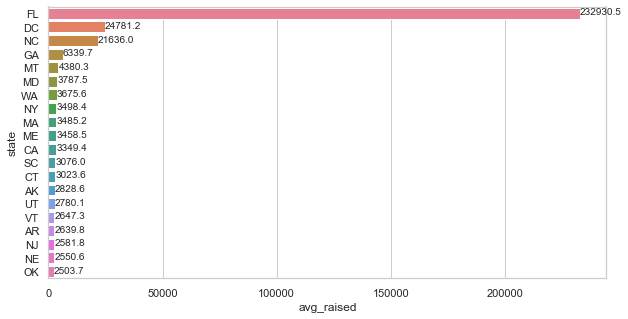

In [34]:
#average raised by states
plt.figure(figsize=(10,5))

ax=sns.barplot(x='avg_raised',y='state',ci=0,data=state_det.sort_values(by='avg_raised',ascending=False).head(20),palette='husl')
plt.ticklabel_format(style='plain', axis='x')

for i, v in enumerate(state_det.sort_values(by='avg_raised',ascending=False).head(20)['avg_raised'].apply(lambda x: round(x, 1)).reset_index(drop=True)):
     ax.text(v-0.1, i+0.1, str(v))

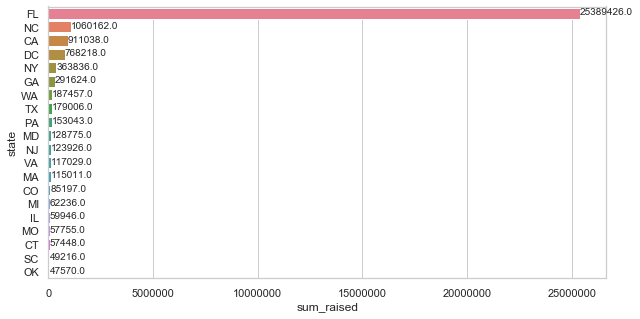

In [35]:
#total raised by states
plt.figure(figsize=(10,5))

ax=sns.barplot(x='sum_raised',y='state',ci=0,data=state_agg.sort_values(by='sum_raised',ascending=False).head(20),palette='husl')
plt.ticklabel_format(style='plain', axis='x')

for i, v in enumerate(state_agg.sort_values(by='sum_raised',ascending=False).head(20)['sum_raised'].apply(lambda x: round(x, 1)).reset_index(drop=True)):
     ax.text(v-0.1, i+0.1, str(v))

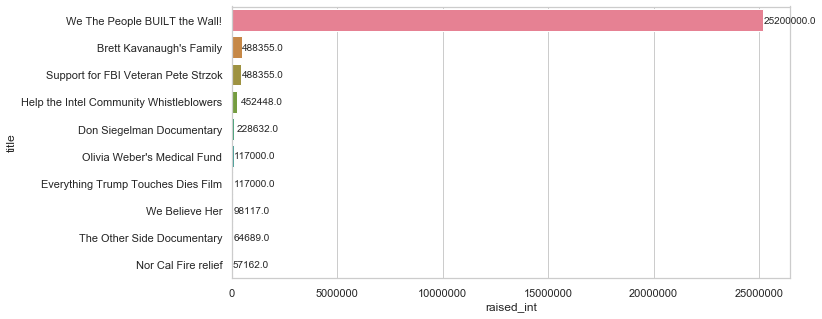

In [36]:
#top 10 campaigns
plt.figure(figsize=(10,5))

ax=sns.barplot(x='raised_int',y='title',ci=0,data=df.sort_values(by='raised_int',ascending=False).head(12),palette='husl')
plt.ticklabel_format(style='plain', axis='x')

for i, v in enumerate(df.sort_values(by='raised_int',ascending=False).head(10)['raised_int'].reset_index(drop=True)):
     ax.text(v-0.1, i+0.1, str(v))



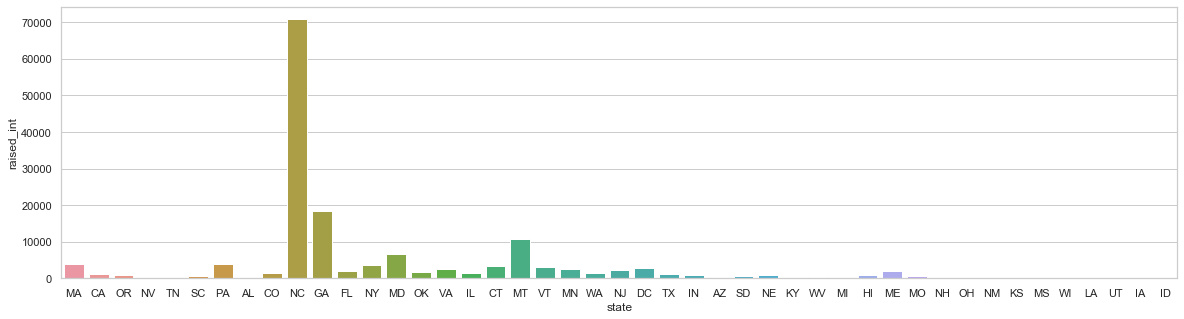

In [37]:
plt.figure(figsize=(20,5))
sns.barplot(x='state',y='raised_int',ci=0,data=overlap)

# Aggregate Graphs


In [ ]:
# #using seaborn time series formatting
# sns.set(rc={'figure.figsize':(11, 4)})

In [39]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1727 entries, 0 to 1538
Data columns (total 14 columns):
Unnamed: 0      1727 non-null int64
created_date    1727 non-null object
funds           1727 non-null object
goal_int        1727 non-null float64
link            1727 non-null object
location        1727 non-null object
raised_int      1727 non-null float64
state           1727 non-null object
summary         1727 non-null object
tag             1727 non-null object
title           1727 non-null object
year            1727 non-null int64
month           1727 non-null int64
weekday_name    1727 non-null object
dtypes: float64(2), int64(3), object(9)
memory usage: 282.4+ KB


In [38]:
df['Weekday Name'] = pd.Categorical(df['Weekday Name'], categories=
    ['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday', 'Sunday'],
    ordered=True)

KeyError: 'Weekday Name'

In [ ]:
created_by_day = df['Weekday Name'].value_counts()
created_by_day = created_by_day.sort_index(ascending=False)
created_by_day.plot(kind='barh',width=0.8,title= "Day of the Week Campaigns Are Created")
plt.savefig("agg_day_of_week_1120.pdf")

In [ ]:
rep_year=df[df['tag']=='rep'].Year.value_counts().rename_axis('Year').reset_index(name='rep_counts')
dem_year =df[df['tag']=='dem'].Year.value_counts().rename_axis('Year').reset_index(name='dem_counts')

In [ ]:
#total amount raised
#what is this scale though? How do I change this?
df.groupby('Year')['raised_int'].sum().plot(kind='barh',title='Total Amount Raised by Campaigns that Mention "Democrat" or "Republican"')

plt.savefig("total_amount_raised_1120.pdf")

In [ ]:
data=pd.DataFrame(df.groupby('Year')['tag'].value_counts())

In [ ]:
df.groupby('tag')['raised_int'].sum().plot(kind='barh',title='Total Raised by Campaigns by Word Mention')

In [ ]:
#another way not as good as crosstab
year_df=rep_year.merge(dem_year, left_on='Year',right_on='Year')
year_df.sort_values('Year').set_index('Year').plot(kind='barh',stacked=True,width=0.8,title='Campaigns Created By Word Mention',figsize=(10,10))
# plt.savefig("campaigns_stacked.pdf")


In [ ]:
# #some other BS I did
rep_Month=df[df['tag']=='rep'].Month.value_counts().rename_axis('Month').reset_index(name='rep_counts')
dem_Month =df[df['tag']=='dem'].Month.value_counts().rename_axis('Month').reset_index(name='dem_counts')
Month_df=rep_Month.merge(dem_Month, left_on='Month',right_on='Month')
Month_df.sort_values('Month').set_index('Month').sort_values(by='Month',ascending=False).plot(kind='barh',stacked=True,width=0.7,title='Campaigns Created By Word Mention')
plt.savefig("campaigns_stacked2.1120.pdf")

In [ ]:
df.sample(5, random_state=0)

In [ ]:
rep_Weekday_Name=df[df['tag']=='rep']['Weekday Name'].value_counts().rename_axis('Weekday Name').reset_index(name='rep_counts')
dem_Weekday_Name =df[df['tag']=='dem']['Weekday Name'].value_counts().rename_axis('Weekday Name').reset_index(name='dem_counts')
Weekday_Name_df=rep_Weekday_Name.merge(dem_Weekday_Name, left_on='Weekday Name',right_on='Weekday Name')
Weekday_Name_df.sort_values('Weekday Name').set_index('Weekday Name').plot(kind='barh',stacked=True,width=0.8,title='Campaigns Created By Word Mention')

plt.savefig("output1120.pdf")

In [ ]:
df.groupby('tag')['Weekday Name'].value_counts()

In [ ]:
#playing with groupbys 
df.groupby('tag')['Weekday Name'].value_counts().plot(kind='barh',stacked=True,width=0.8,title='Campaigns Created By Word Mention')

In [ ]:
df.sample(3, random_state=0)

In [ ]:
#the graveyard

graveyard = df[df['raised_int']==0]
sns.relplot(data=graveyard, x='weekday_name', y='goal_int', hue='tag')

# Common Words!

In [ ]:
#campaigns with the word republican
top_N = 100000
rep_rslt =pd.DataFrame()
for index, row in df[df['tag']=='rep'].iterrows():
    txt = row['summary'].lower()
    words = nltk.tokenize.word_tokenize(txt)
    word_dist = nltk.FreqDist(words)
    stopwords = nltk.corpus.stopwords.words('english')
    words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
    print('All frequencies, including STOPWORDS:')
    print('=' * 60)
    rslt = pd.DataFrame(word_dist.most_common(top_N),
                        columns=['Word', 'Frequency'])
    print(rslt)
    print('=' * 60)
    rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),columns=['Word', 'Frequency']).set_index('Word')
    rep_rslt=rep_rslt.append(rslt)

In [ ]:
rep_rslt.index.value_counts().head(20).sort_values(ascending=True).plot(kind='barh',figsize=(30,10))

In [ ]:
# rep_rslt['count'] =1
# rep_rslt=rep_rslt.groupby('Word').agg({'count':'sum'})


In [ ]:
rep_rslt.info()

In [ ]:
rep_rslt=rep_rslt.reset_index()
rep_rslt['tag']='rep'
rep_rslt=rep_rslt.rename(columns={'count':'Frequency'})
rep_rslt['wd_pct']=rep_rslt['Frequency']/876


In [ ]:
rep_rslt.sort_values('wd_pct',ascending=False)

In [ ]:
rep_rslt.sort_values('wd_pct',ascending=False)[20:30].plot(x='Word',y='wd_pct',kind='barh',figsize=(30,20))

In [ ]:
#campaigns with the word democrat
top_N = 500
txt = df[df['tag']=='dem']['summary'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)
dem_rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
dem_rslt['tag']='dem'
dem_rslt['wd_pct']=dem_rslt['Frequency']/1316
# matplotlib.style.use('ggplot')
dem_rslt[20:30].plot.bar(rot=0,figsize=(30,10))

In [ ]:
rep_rslt.head(10)

In [ ]:
#all words
top_N = 500
txt = df['summary'].str.lower().str.replace(r'\|', ' ').str.cat(sep=' ')
words = nltk.tokenize.word_tokenize(txt)
word_dist = nltk.FreqDist(words)
stopwords = nltk.corpus.stopwords.words('english')
words_except_stop_dist = nltk.FreqDist(w for w in words if w not in stopwords) 
print('All frequencies, including STOPWORDS:')
print('=' * 60)
rslt = pd.DataFrame(word_dist.most_common(top_N),
                    columns=['Word', 'Frequency'])
print(rslt)
print('=' * 60)
rslt = pd.DataFrame(words_except_stop_dist.most_common(top_N),
                    columns=['Word', 'Frequency']).set_index('Word')
matplotlib.style.use('ggplot')
rslt[20:30].plot.bar(rot=0,figsize=(30,10))

In [ ]:
words_df=rep_rslt.append(dem_rslt)
words_df=words_df.reset_index()


In [ ]:
rslt=rslt.reset_index()

In [ ]:
ser_df=rslt
ser_df=ser_df.rename(columns={'Frequency':'total'})


In [ ]:
ser_df.head(3)

In [ ]:
words_df=words_df.merge(ser_df,left_on='Word',right_on='Word',how='left')
words_df.head()

In [ ]:
ser_df[ser_df['Word']=='republican']

In [ ]:
rslt[rslt['Word']=='republican']

In [ ]:
words_df[words_df['Word']=='republican']

In [ ]:
ser=words_df.total

In [ ]:
words_df['word_bin']=pd.qcut(ser, q=5,labels=['1','2','3','4','5'])

# sns.catplot(kind='bar',x='Frequency',y='Word',hue='tag',row='word_bin',data=words_df,height=20,aspect=2)

In [ ]:
#making individual bins because 
words_df_3=words_df[words_df['word_bin']=='3']
words_df_1=words_df[words_df['word_bin']=='1']
words_df_2=words_df[words_df['word_bin']=='2']
words_df_4=words_df[words_df['word_bin']=='4']
words_df_5=words_df[words_df['word_bin']=='5']

In [ ]:
words_df_3.Word.unique()

In [ ]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_3[words_df_3.Word.isin(['$', '--','-', '?',"'m",'``',"''",';','“','”','nonetype'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [ ]:
words_df_5.Word.unique()

In [ ]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_5[words_df_5.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';','(',')',"n't",'--','-'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [ ]:
sns.catplot(y="Word", x="wd_pct", hue="tag", kind="bar", 
            data=words_df_4[words_df_4.Word.isin([',', '.',"'s", '’', ':','(',')',"'m","''",'``','“',"'ve",';'])==False], 
            height=7, aspect=11.7/8.27,palette='husl')

In [ ]:
ser 